In [1]:
import numpy as np
import random
import math
import copy
import time

class Solution(object):
    def __init__(self):
        self.path = []
        self.code = []
        self.fitness = float('inf')
        self.velocity = []
        self.best_local_code = []
        self.best_local_fitness = float('inf')


class BMA:

    def __init__(self, src, dst, N, Max, K_paths, w, c1, c2):
        self.switches = [i for i in range(1,21)]
        self.src= src
        self.dst = dst
        self.weight_map= self.GetWeightMap()
        self.adjacency = copy.deepcopy(self.weight_map)
        self.N = N
        self.Max = Max
        self.K_paths = K_paths
        self.best_global_solution = Solution()
        self.population = [self.CreateSolution() for i in range(self.N)]
        self.condidates = []
        self.best = []
        self.w = w
        self.c1 = c1
        self.c2 = c2
    
    def GetWeightMap(self):
        weight_map={}
        temp = 0
        with open('metric_data_20_new.txt') as f:
            for line in f:
                strt = line
                strt2 = strt.split(':')
                my_result = list(map(int, strt2[0].split(',')))
                if (temp!=my_result[0]):
                    weight_map[my_result[0]]={}
                weight_map[my_result[0]][my_result[1]] = int(strt2[1])
                temp = my_result[0]
        return weight_map

    def CreateSolution(self):
        newSolution = Solution()
        path=[]
        code = []
        while(len(path)==0):
            code.clear()
            path.clear()
            code = copy.deepcopy([random.uniform(-1,1) for i in range(len(self.switches))])
            path = copy.deepcopy(self.Decode(code))
        newSolution.code = copy.deepcopy(code)
        newSolution.path = copy.deepcopy(path)
        newSolution.velocity = [random.uniform(-1,1) for i in range(len(self.switches))]
        newSolution.fitness = self.Evaluate(newSolution.path)
        newSolution.best_local_code= copy.deepcopy(code)
        newSolution.best_local_fitness = newSolution.fitness
        if(newSolution.best_local_fitness<=self.best_global_solution.fitness):
            self.best_global_solution.code = copy.deepcopy(newSolution.best_local_code)
            self.best_global_solution.fitness = copy.deepcopy(newSolution.best_local_fitness)
        return newSolution
    
    def Decode(self,code):
        path = []
        path.append(self.src)
        current_switch = self.src
        while(current_switch!=self.dst):
            neighbor_switches = set(self.adjacency[current_switch].keys())-set(path)
            neighbor_switches = list(neighbor_switches)
            if(len(neighbor_switches)==0):
                path.clear()
                break
            switch_min = 1
            min = float('inf')
            for switch in neighbor_switches:
                if(code[switch-1] <= min):
                    min = code[switch-1]
                    switch_min = switch
            current_switch = switch_min
            path.append(current_switch)
        return path

    def Evaluate(self,path):
        calculatedFitness = 0
        for i in range(len(path) - 1):
            p1 = path[i]
            p2 = path[i + 1]
            calculatedFitness += self.weight_map[p1][p2]
        return calculatedFitness
    
    def Normalize(self,code):
        code_2 = copy.deepcopy(code)
        mn = min(code_2)
        mx = max(code_2)
        for j in range(len(self.switches)):
            code[j] = -1+2*(code_2[j]-mn)/(mx-mn)
        return code
    
    def UpdateLocalGlobal(self,solution):
        if(solution.fitness<=solution.best_local_fitness):
            solution.best_local_code = copy.deepcopy(solution.code)
            solution.best_local_fitness = solution.fitness
            if(solution.best_local_fitness<=self.best_global_solution.fitness):
                self.best_global_solution.code = copy.deepcopy(solution.best_local_code)
                self.best_global_solution.fitness = copy.deepcopy(solution.best_local_fitness)

    def UpdateVelocityPosition(self):
        for i in range(self.N):
            velocity = copy.deepcopy(self.population[i].velocity)
            code = copy.deepcopy(self.population[i].code)
            path = []
            while(len(path)==0):
                for j in range(len(self.switches)):
                    r0 = np.random.rand()
                    r1 = np.random.rand()
                    r2 = np.random.rand()
                    v1 = self.c1*r1*(self.population[i].best_local_code[j]-self.population[i].code[j])
                    v2 = self.c2*r2*(self.best_global_solution.code[j]-self.population[i].code[j])
                    velocity[j] = self.w*r0*self.population[i].velocity[j] + v1 + v2
                velocity = self.Normalize(velocity)
                for j in range(len(self.switches)):
                    code[j] = self.population[i].code[j] + velocity[j]
                code = self.Normalize(code)
                path = copy.deepcopy(self.Decode(code))
            self.population[i].velocity = copy.deepcopy(velocity)
            self.population[i].code = copy.deepcopy(code)
            self.population[i].path = copy.deepcopy(path)
            self.population[i].fitness = self.Evaluate(self.population[i].path)
            self.UpdateLocalGlobal(self.population[i])
            

    def MemorizeCondidates(self):
        self.population.sort(key=lambda x: x.fitness)
        condidate = []
        k=0
        for i in range(len(self.population)):
            dk_3 = False
            for member in condidate:
                if(tuple(member.path)==tuple(self.population[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                condidate.append(copy.deepcopy(self.population[i]))
                k=k+1
            if(k==self.K_paths):
                break
        self.condidates.extend(copy.deepcopy(condidate))
    
    def GetBest(self):
        self.condidates.sort(key=lambda x: x.fitness)
        self.best.clear()
        k=0
        for i in range(len(self.condidates)):
            dk_3 = False
            for solution in self.best:
                if(tuple(solution.path)==tuple(self.condidates[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                self.best.append(copy.deepcopy(self.condidates[i]))
                k=k+1
            if(k==self.K_paths):
                break

    def Do(self):
        for i in range(self.Max):
            self.UpdateVelocityPosition()
            self.MemorizeCondidates()
        self.GetBest()

In [2]:
Times = 100
N = [10,15,20]
Max = 100
K_paths = 10
w = 2
c1 = 1
c2 = 0.1

In [3]:
import numpy as np
import random
import math
import copy
from YenAlgorithm import YenAlgorithm
import time
weight_map={}
temp = 0
with open('metric_data_20_new.txt') as f:
    for line in f:
        strt = line
        strt2 = strt.split(':')
        my_result = list(map(int, strt2[0].split(',')))
        if (temp!=my_result[0]):
            weight_map[my_result[0]]={}
        weight_map[my_result[0]][my_result[1]] = int(strt2[1])
        temp = my_result[0]
vertices = [i for i in range(1,21)]
alg_y = YenAlgorithm(weight_map,vertices,2,7,K_paths)
paths_vertices = alg_y.compute_shortest_paths()

In [4]:
paths_vertices

[[2, 11, 6, 14, 7],
 [2, 9, 10, 12, 13, 7],
 [2, 1, 11, 6, 14, 7],
 [2, 1, 3, 4, 8, 7],
 [2, 15, 18, 5, 7],
 [2, 15, 18, 4, 8, 7],
 [2, 1, 3, 6, 14, 7],
 [2, 16, 17, 19, 20, 7],
 [2, 15, 18, 5, 8, 7],
 [2, 11, 6, 12, 13, 7]]

In [5]:
paths_length = []
for path in paths_vertices:
    s = 0
    for i in range(len(path)-1):
        s+= weight_map[path[i]][path[i+1]]
    paths_length.append(s)
sum(paths_length)

1630

In [6]:
paths_length

[140, 140, 150, 150, 165, 165, 175, 180, 180, 185]

In [7]:
import time
time_1 = []
time_2 = []
time_3 = []
solan_1 = np.zeros(K_paths)
solan_2 = np.zeros(K_paths)
solan_3 = np.zeros(K_paths)
CD_1 = []
CD_2 = []
CD_3 = []

In [8]:
for i in range(Times):
    alg_1 = BMA(2,7,N[0], Max,K_paths, w, c1, c2)
    start_1 = time.time()
    alg_1.Do()
    end_1 = time.time()
    time_1.append(end_1 - start_1)
    for j in range(len(paths_vertices)):
        for j2 in range(len(alg_1.best)):
            if(tuple(alg_1.best[j2].path)==tuple(paths_vertices[j])):
                solan_1[j]+=1
                break
    s = 0
    for member in alg_1.best:
        for i in range(len(member.path)-1):
            s+= alg_1.weight_map[member.path[i]][member.path[i+1]]
    CD_1.append(s)

In [9]:
for i in range(Times):        
    alg_2 = BMA(2,7,N[1], Max,K_paths, w, c1, c2)
    start_2 = time.time()
    alg_2.Do()
    end_2 = time.time()
    time_2.append(end_2 - start_2)
    for j in range(len(paths_vertices)):
        for j2 in range(len(alg_2.best)):
            if(tuple(alg_2.best[j2].path)==tuple(paths_vertices[j])):
                solan_2[j]+=1
                break
    s = 0
    for member in alg_2.best:
        for i in range(len(member.path)-1):
            s+= alg_2.weight_map[member.path[i]][member.path[i+1]]
    CD_2.append(s)

In [10]:
for i in range(Times): 
    alg_3 = BMA(2,7,N[2], Max,K_paths, w, c1, c2)
    start_3 = time.time()
    alg_3.Do()
    end_3 = time.time()
    time_3.append(end_3 - start_3)
    for j in range(len(paths_vertices)):
        for j2 in range(len(alg_3.best)):
            if(tuple(alg_3.best[j2].path)==tuple(paths_vertices[j])):
                solan_3[j]+=1
                break
    s = 0
    for member in alg_3.best:
        for i in range(len(member.path)-1):
            s+= alg_3.weight_map[member.path[i]][member.path[i+1]]
    CD_3.append(s)

In [11]:
print(solan_1)
print(solan_2)
print(solan_3)

[ 75.  98.  62.  84.  83.  60.  74. 100.  60.  93.]
[ 82.  99.  75.  93.  94.  77.  75. 100.  60.  95.]
[ 91. 100.  91.  99.  95.  92.  87. 100.  84. 100.]


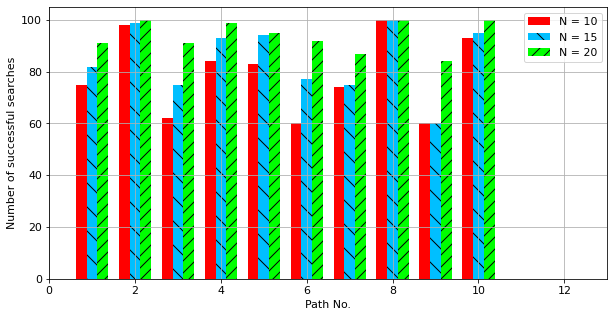

In [22]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
font = {'size'   : 11}
matplotlib.rc('font', **font)
# create data
x = np.arange(K_paths)+1
width = 0.25
  
# plot data in grouped manner of bar type
fig = plt.figure(figsize=(10,5))
plt.xlim(0,13)
plt.bar(x-0.25, solan_1, width, color='red')
plt.bar(x, solan_2, width, color='deepskyblue', hatch='\\')
plt.bar(x+0.25, solan_3, width, color='lime', hatch='//')
plt.xlabel("Path No.")
plt.ylabel("Number of successful searches")
plt.legend(["N = "+str(N[0]), "N = "+str(N[1]), "N = "+str(N[2])],loc="upper right")
plt.grid()
plt.savefig("PSO/BMA_N_20_new.png",dpi=200)

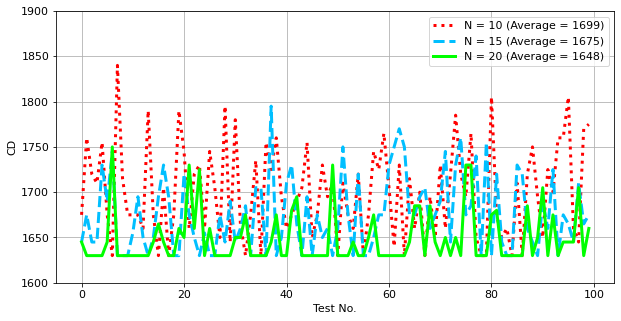

In [23]:
figg1 = plt.figure(figsize=(10,5))
avr_1 = int(sum(CD_1)/Times)
avr_2 = int(sum(CD_2)/Times)
avr_3 = int(sum(CD_3)/Times)
plt.ylim(1600,1900)
plt.plot(CD_1, label = "N = "+str(N[0])+ " (Average = "+str(avr_1)+")", linewidth = '3', color='red', linestyle = 'dotted')
plt.plot(CD_2, label = "N = "+str(N[1])+ " (Average = "+str(avr_2)+")", linewidth = '3', color='deepskyblue', linestyle = 'dashed')
plt.plot(CD_3, label = "N = "+str(N[2])+ " (Average = "+str(avr_3)+")", linewidth = '3', color='lime')
plt.legend(loc="upper right")
plt.xlabel("Test No.")
plt.ylabel("CD")
plt.grid()
plt.savefig("PSO/BMA_N_20_new_CD.png",dpi=200)

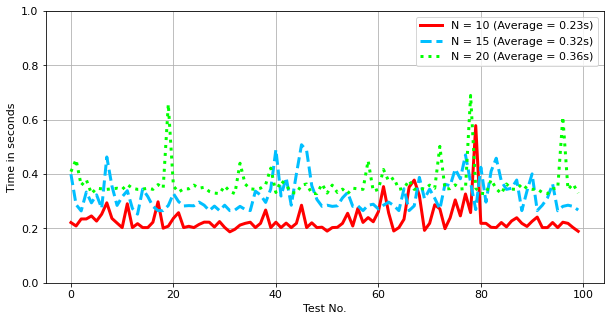

In [25]:
figg2 = plt.figure(figsize=(10,5))
avr_1 = round(sum(time_1)/Times,2)
avr_2 = round(sum(time_2)/Times,2)
avr_3 = round(sum(time_3)/Times,2)
plt.ylim(0,1)
plt.plot(time_1, label = "N = "+str(N[0])+  " (Average = "+str(avr_1)+"s)", linewidth = '3', color='red')
plt.plot(time_2, label = "N = "+str(N[1])+  " (Average = "+str(avr_2)+"s)", linewidth = '3', color='deepskyblue', linestyle = 'dashed')
plt.plot(time_3, label = "N = "+str(N[2])+  " (Average = "+str(avr_3)+"s)", linewidth = '3', color='lime', linestyle = 'dotted')
plt.legend(loc="upper right")
plt.xlabel("Test No.")
plt.ylabel("Time in seconds")
plt.grid()
plt.savefig("PSO/BMA_N_20_new_time.png",dpi=200)